## Download the dataset from the following link before using this notebook (Pavia Centre scene):

##  https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes

## Import required libraries

In [1]:
from scipy.io import loadmat
import numpy as np
import tensorflow as tf
import random
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Input, SeparableConv2D, Conv2D, Conv2DTranspose, Add,
                                     Activation, BatchNormalization, UpSampling2D, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim

2025-05-08 14:52:06.733685: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 14:52:06.748091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746705126.764125 3172198 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746705126.769157 3172198 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-08 14:52:06.786133: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

##  Reproducibility Setup ( Set a consistent random seed for NumPy, TensorFlow, and Python's random module to ensure the same results on each run)

In [2]:
seed_value = 65
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

tf.config.experimental.enable_op_determinism()
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

##  Load the PaviaC Dataset

In [3]:
data = loadmat("Pavia.mat")
if 'pavia' not in data:
    raise KeyError("'pavia' not found in the .mat file.")
hyperspectral_image = data['pavia'].astype(np.float32)

##  Parameter Initialization for dataset preprocessing only

In [4]:
patch_size = (144, 144)
downscale_factor = 2
nodata_value = -1
group_size = 32
overlap_size = 8
validation_ratio = 0.1

## Define Test Patch (Bottom-Center)

In [5]:
H, W, _ = hyperspectral_image.shape
patch_h, patch_w = patch_size
test_i = H - patch_h
test_j = (W - patch_w) // 2
test_coords = (test_i, test_j)

# Extract test patch
test_hr_full = hyperspectral_image[test_i:test_i + patch_h, test_j:test_j + patch_w, :]
test_lr_full = tf.image.resize(test_hr_full,
                               size=(patch_h // downscale_factor, patch_w // downscale_factor),
                               method='area').numpy()
test_hr_full = test_hr_full[np.newaxis, ...]
test_lr_full = test_lr_full[np.newaxis, ...]



I0000 00:00:1746705131.278906 3172198 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


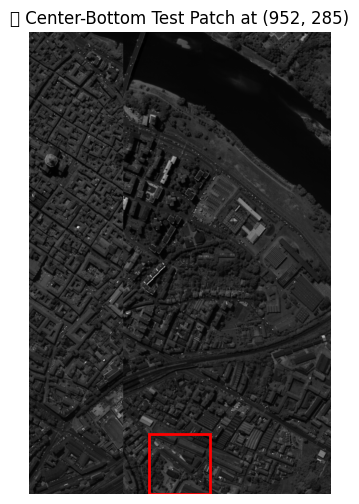

In [6]:
# -----------------------------
# Visualize test patch
# -----------------------------
plt.figure(figsize=(6, 6))
plt.imshow(np.mean(hyperspectral_image, axis=-1), cmap='gray')
plt.gca().add_patch(plt.Rectangle((test_j, test_i), patch_w, patch_h,
                                  edgecolor='red', facecolor='none', linewidth=2))
plt.title(f"📍 Center-Bottom Test Patch at {test_coords}")
plt.axis('off')
plt.show()

## Extract Training Patches

In [7]:
def extract_training_patches(data, patch_size, downscale_factor, nodata_value, test_coords):
    h, w, b = data.shape
    i_test, j_test = test_coords
    patch_h, patch_w = patch_size
    train_hr, train_lr = [], []

    for i in range(0, h - patch_h + 1, patch_h):
        for j in range(0, w - patch_w + 1, patch_w):
            if i == i_test and j == j_test:
                continue  # avoid test patch
            patch = data[i:i + patch_h, j:j + patch_w, :]
            if patch.shape[:2] != patch_size or np.any(patch == nodata_value):
                continue
            patch_lr = tf.image.resize(patch,
                                       size=(patch_h // downscale_factor, patch_w // downscale_factor),
                                       method='area').numpy()
            train_hr.append(patch)
            train_lr.append(patch_lr)
    return np.array(train_hr), np.array(train_lr)

train_hr_full, train_lr_full = extract_training_patches(
    hyperspectral_image, patch_size, downscale_factor, nodata_value, test_coords
)

## Band grouping 


In [8]:
def apply_band_grouping(patches, group_size, overlap_size):
    grouped = []
    for patch in patches:
        h, w, bands = patch.shape
        step = group_size - overlap_size
        for g in range(0, bands - group_size + 1, step):
            grouped_patch = patch[:, :, g:g + group_size]
            grouped.append(grouped_patch)
    return np.array(grouped)

X_train_hr = apply_band_grouping(train_hr_full, group_size, overlap_size)
X_train_lr = apply_band_grouping(train_lr_full, group_size, overlap_size)
X_test_hr = apply_band_grouping(test_hr_full, group_size, overlap_size)
X_test_lr = apply_band_grouping(test_lr_full, group_size, overlap_size)

## Validation Split FOR train and validation

In [9]:
num_train = X_train_hr.shape[0]
val_size = max(1, int(validation_ratio * num_train))
indices = np.arange(num_train)
np.random.shuffle(indices)
X_train_hr = X_train_hr[indices]
X_train_lr = X_train_lr[indices]
X_validation_hr = X_train_hr[:val_size]
X_validation_lr = X_train_lr[:val_size]
X_train_hr = X_train_hr[val_size:]
X_train_lr = X_train_lr[val_size:]

## Print database sizes to output the number of patches, patch height, width, and band group size for each subset.

In [10]:
print("Hyperspectral image shape:", hyperspectral_image.shape)
print("Train set (HR):", X_train_hr.shape)
print("Train set (LR):", X_train_lr.shape)
print("Validation set (HR):", X_validation_hr.shape)
print("Validation set (LR):", X_validation_lr.shape)
print("Test set (HR):", X_test_hr.shape)
print("Test set (LR):", X_test_lr.shape)

Hyperspectral image shape: (1096, 715, 102)
Train set (HR): (76, 144, 144, 32)
Train set (LR): (76, 72, 72, 32)
Validation set (HR): (8, 144, 144, 32)
Validation set (LR): (8, 72, 72, 32)
Test set (HR): (3, 144, 144, 32)
Test set (LR): (3, 72, 72, 32)


##  Model development for Depthwise Separable Dilated Convolutional Network (https://arxiv.org/pdf/2505.00374)

In [11]:
# -----------------------------
# Residual Block (Depthwise Separable)
# -----------------------------
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# -----------------------------
# Dilated Fusion Block
# -----------------------------
def dilated_fusion_block(x, filters):
    d1 = Conv2D(filters, 3, padding='same', dilation_rate=1, activation='relu')(x)
    d2 = Conv2D(filters, 3, padding='same', dilation_rate=2, activation='relu')(x)
    d3 = Conv2D(filters, 3, padding='same', dilation_rate=3, activation='relu')(x)
    fused = Concatenate()([d1, d2, d3])
    fused = Conv2D(filters, 1, padding='same', activation='relu')(fused)
    return fused

# -----------------------------
# Upsample Block (Modular)
# -----------------------------
def upsample_block(x, filters, scale=2, use_residual=False, use_depthwise=True, use_transpose=False):
    shortcut = x  # for optional residual connection

    if use_transpose:
        x = Conv2DTranspose(filters, kernel_size=4, strides=scale, padding='same', activation='relu')(x)
    else:
        x = UpSampling2D(size=(scale, scale), interpolation='bilinear')(x)
        if use_depthwise:
            x = SeparableConv2D(filters, 3, padding='same', activation='relu')(x)
        else:
            x = Conv2D(filters, 3, padding='same', activation='relu')(x)

    if use_residual:
        if shortcut.shape[-1] != filters or shortcut.shape[1] != x.shape[1] or shortcut.shape[2] != x.shape[2]:
            shortcut = Conv2D(filters, 1, padding='same')(UpSampling2D(size=(scale, scale))(shortcut))
        x = Add()([x, shortcut])

    return x

# -----------------------------
# Spectral Angle Mapper (SAM) Loss
# -----------------------------
def spectral_angle_loss(y_true, y_pred):
    y_true = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred = tf.nn.l2_normalize(y_pred, axis=-1)
    dot_product = tf.reduce_sum(y_true * y_pred, axis=-1)
    angle = tf.acos(tf.clip_by_value(dot_product, -1.0, 1.0))
    return tf.reduce_mean(angle)

# -----------------------------
# L2 Loss (Squared Error Sum)
# -----------------------------
def l2_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# -----------------------------
# Combined Loss: MSE + λ₁ × SAM + λ₂ × L2
# -----------------------------
def combined_loss(lambda_sam=0.1, lambda_l2=0.1):
    mse = MeanSquaredError()
    def loss_fn(y_true, y_pred):
        return mse(y_true, y_pred) + lambda_sam * spectral_angle_loss(y_true, y_pred) + lambda_l2 * l2_loss(y_true, y_pred)
    return loss_fn

# -----------------------------
# Super-Resolution Model with Modular Upsampling
# -----------------------------
def build_simple_sr_model(input_shape,
                          use_transpose=True,
                          use_depthwise=True,
                          use_residual=True):
    inputs = Input(shape=input_shape)

    # Initial feature extraction
    x = SeparableConv2D(64, 3, padding='same', activation='relu')(inputs)

    # Residual blocks
    for _ in range(3):
        x = residual_block(x, 64)

    # Dilated Fusion Block
    x = dilated_fusion_block(x, 64)

    # Upsample x2 → x4 → x8
    x = upsample_block(x, filters=128, scale=2,
                       use_residual=use_residual,
                       use_depthwise=use_depthwise,
                       use_transpose=use_transpose)

    # Final spectral reconstruction
    output = SeparableConv2D(input_shape[-1], 3, padding='same', activation='linear')(x)

    model = Model(inputs, output, name='HSI_SR_Modular_Upsample_Model')
    return model


# -----------------------------
# Model Compilation
# -----------------------------
input_shape = (72, 72, 32)  # Low-resolution input shape (e.g. 1/8 of 144x144)
model = build_simple_sr_model(
    input_shape=input_shape,
    use_transpose=True,         # Toggle between bilinear or transposed
    use_depthwise=True,
    use_residual=True
)

model.compile(
    optimizer='adam',
    loss=combined_loss(lambda_sam=0.1, lambda_l2=0.08),
    metrics=['mse']
)
total_params = model.count_params()
size_in_bytes = total_params * 4  # 4 bytes per float32 param
size_in_mb = size_in_bytes / (1024 ** 2)
print(f"💾 Model size: {size_in_mb:.2f} MB")

#model.summary()

total_params = model.count_params()
params_in_millions = total_params / 1e6
print(f"\n🧠 Total Parameters: {params_in_millions:.2f} Million")

💾 Model size: 1.15 MB

🧠 Total Parameters: 0.30 Million


Epoch 1/1000


I0000 00:00:1746705156.865325 3172250 service.cc:148] XLA service 0x7effd4014fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746705156.865353 3172250 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-05-08 14:52:36.988711: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746705157.514352 3172250 cuda_dnn.cc:529] Loaded cuDNN version 90501


 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1635359.0000 - mse: 1514221.1250

I0000 00:00:1746705161.029445 3172250 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 1298829.8750 - mse: 1202620.1250 - val_loss: 335132.8438 - val_mse: 310308.1562
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 272996.3750 - mse: 252774.4375 - val_loss: 235866.2031 - val_mse: 218394.6250
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 176340.2344 - mse: 163277.9844 - val_loss: 174175.6250 - val_mse: 161273.7031
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 129228.0938 - mse: 119655.6250 - val_loss: 144882.3438 - val_mse: 134150.2969
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 108089.3203 - mse: 100082.6797 - val_loss: 120169.6641 - val_mse: 111268.1953
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 87132.5156 - mse: 80678.2344 - val_loss: 92958.7969 - val_mse: 86072.9453
Epoch 7/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 66999.3984 - mse: 62036.4688 - val_loss: 73201.5625 - val_mse: 67779.2109
Epoch 8/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22

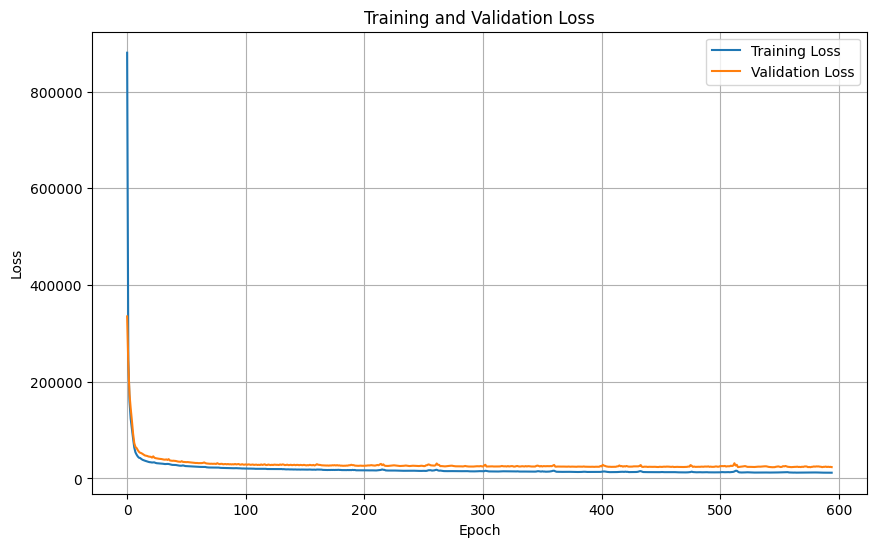

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model and get the training history with early stopping
history = model.fit(
    X_train_lr, 
    X_train_hr, 
    epochs=1000, 
    batch_size=4, 
    validation_data=(X_validation_lr, X_validation_hr),
    callbacks=[early_stopping]  # Add the early stopping callback here
)

# Visualize training and validation loss over epochs
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()

##  Save trained model

In [13]:
model.save('PaviaC_2x_saved_model.keras')

## Report the six types of results in terms of PSNR, SSIM, SAM, Correlation Coefficient, ERGAS, and RMSE.

In [15]:
def psnr(y_true, y_pred, max_pixel=None):
    """
    Compute PSNR for each spectral band separately and return the average.
    
    Args:
        y_true: Ground truth image, shape (H, W, B)
        y_pred: Super-resolved image, shape (H, W, B)
        max_pixel: Maximum pixel value (None = use actual max from y_true)
    
    Returns:
        Average PSNR across all bands
    """
    if max_pixel is None:
        max_pixel = np.max(y_true)  # Auto-detect max value if not provided

    B = y_true.shape[-1]  # Number of spectral bands
    psnr_values = []
    
    for i in range(B):  # Loop over bands
        mse = np.mean((y_true[..., i] - y_pred[..., i]) ** 2)
        if mse == 0:
            psnr_values.append(float('inf'))  # Perfect reconstruction
        else:
            psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
            psnr_values.append(psnr)
    
    return np.mean(psnr_values)  # Average across bands

# Function to calculate SSIM with channel_axis
def ssim_value(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape} vs y_pred shape {y_pred.shape}")
    
    data_range = y_true.max() - y_true.min()  # Calculate data range from y_true
    ssim_val = ssim(y_true, y_pred, data_range=data_range, channel_axis=-1)
    return ssim_val

# Function to calculate Correlation Coefficient
def correlation_coefficient(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    corr_matrix = np.corrcoef(y_true_flat, y_pred_flat)
    corr_value = corr_matrix[0, 1]
    return corr_value

# Function to calculate Spectral Angle Mapper (SAM) in degrees
def sam(y_true, y_pred):
    y_true_reshaped = y_true.reshape(-1, y_true.shape[-1])
    y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])
    
    non_zero_mask = (np.linalg.norm(y_true_reshaped, axis=1) > 1e-10) & (np.linalg.norm(y_pred_reshaped, axis=1) > 1e-10)
    dot_product = np.sum(y_true_reshaped[non_zero_mask] * y_pred_reshaped[non_zero_mask], axis=1)
    norm_true = np.linalg.norm(y_true_reshaped[non_zero_mask], axis=1)
    norm_pred = np.linalg.norm(y_pred_reshaped[non_zero_mask], axis=1)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        angles = np.arccos(np.clip(dot_product / (norm_true * norm_pred), -1.0, 1.0))
    
    if angles.size > 0:
        sam_value_degrees = np.mean(angles) * (180 / np.pi)
    else:
        sam_value_degrees = 0
    
    return sam_value_degrees

# Function to normalize the images
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)  # Normalize to [0, 1]

# Function to calculate Root Mean Squared Error (RMSE) for hyperspectral images (normalized)
def rmse_bandwise(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch between true and predicted images.")
    
    bands = y_true.shape[-1]
    rmse_per_band = []

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        
        mse_band = np.mean((band_true - band_pred) ** 2)
        rmse_band_value = np.sqrt(mse_band)
        rmse_per_band.append(rmse_band_value)

    # Normalize RMSE by the maximum value in y_true across all bands
    max_value = np.max(y_true)
    normalized_rmse = np.mean(rmse_per_band) / max_value
    return normalized_rmse

# Function to calculate ERGAS
def ergas(y_true, y_pred, scale):
    bands = y_true.shape[-1]
    ergas_value = 0
    
    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        mean_band_true = np.mean(band_true)
        
        # Calculate RMSE for the band without using a separate function
        mse_band = np.mean((band_true - band_pred) ** 2)  # Mean Squared Error for the band
        rmse_band = np.sqrt(mse_band)  # Root Mean Squared Error for the band
        
        ergas_value += (rmse_band / mean_band_true) ** 2
    
    ergas_value = 100 * (1 / scale) * np.sqrt(ergas_value / bands)
    return ergas_value

# Assuming hybrid_sr_model is trained, and X_test_lr, X_test_hr are defined
predicted_hr_images =  model.predict(X_test_lr)

downscale_factor = 2 # ERGAS downscale factor

# Validate shapes match for test and predictions
if predicted_hr_images.shape != X_test_hr.shape:
    raise ValueError(f"Shape mismatch: predicted_hr_images shape {predicted_hr_images.shape} vs X_test_hr shape {X_test_hr.shape}")

# Calculate metrics per test sample
psnr_values, ssim_values, cc_values, sam_values, ergas_values, rmse_values = [], [], [], [], [], []

for i in range(len(X_test_hr)):
    psnr_values.append(psnr(X_test_hr[i], predicted_hr_images[i]))
    ssim_values.append(ssim_value(X_test_hr[i], predicted_hr_images[i]))
    cc_values.append(correlation_coefficient(X_test_hr[i], predicted_hr_images[i]))
    sam_values.append(sam(X_test_hr[i], predicted_hr_images[i]))
    ergas_values.append(ergas(X_test_hr[i], predicted_hr_images[i], downscale_factor))
    rmse_values.append(rmse_bandwise(X_test_hr[i], predicted_hr_images[i]))

# Average metrics
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_cc = np.mean(cc_values)
average_sam = np.mean(sam_values)
average_ergas = np.mean(ergas_values)
average_rmse = np.mean(rmse_values)

# Print the evaluation metrics
print("Average PSNR on the test set:", average_psnr)
print("Average SSIM on the test set:", average_ssim)
print("Average SAM on the test set (in degrees):", average_sam)
print("Average Correlation Coefficient on the test set:", average_cc)
print("Average ERGAS on the test set:", average_ergas)
print("Average RMSE:", average_rmse)  # Indicate RMSE is normalized

2025-05-08 14:56:56.839356: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Average PSNR on the test set: 36.43427769343058
Average SSIM on the test set: 0.9578933
Average SAM on the test set (in degrees): 3.5386439559120313
Average Correlation Coefficient on the test set: 0.982357992827409
Average ERGAS on the test set: 5.881299886951079
Average RMSE: 0.0152413575
